In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import osmnx as ox
import pandas as pd
import pickle
import tensorflow as tf

In [2]:
tf.__version__

'1.12.0'

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Load the model
Load the training supposed best training checkpoint. Then put the weight into a newly generated model that can handel a single batch.

In [4]:
DATASET_NAME = 'cabspotting'
GRU_SIZE = 32
setup_string = 'GRU-{gru_size}_TD-Dense-3_{dataset}_64_100_adam_mae_default'.format(dataset=DATASET_NAME,
                                                                                    gru_size=GRU_SIZE)

In [5]:
setup_string

'GRU-32_TD-Dense-3_cabspotting_64_100_adam_mae_default'

In [6]:
history = pickle.load(open('histories/citybased_rnn_2/' + setup_string + '_30.pkl', 'rb'))

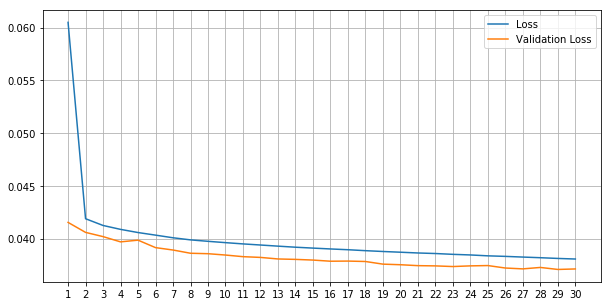

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 31, 1), history['loss'], label='Loss')
plt.plot(np.arange(1, 31, 1), history['val_loss'], label='Validation Loss')
plt.xticks(np.arange(1, 31, 1))
plt.grid()
plt.legend()
plt.show()

In [8]:
SELECTED_EPOCH = 30

In [9]:
# Load the model
model_path = 'checkpoints/citybased_rnn_2/' + setup_string + '_{:02}.h5'.format(SELECTED_EPOCH)
loaded_model = tf.keras.models.load_model(model_path)

In [10]:
def build_model(batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(GRU_SIZE, return_sequences=True, stateful=True, input_shape=(None, 3), batch_size=batch_size),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3))
    ])
    return model

In [11]:
model = build_model(batch_size=1)
model.set_weights(loaded_model.get_weights())

## Actual generation

In [12]:
N_USERS = 8

Generate user start positions

In [13]:
poskde = pickle.load(open('../data_{dataset}/poskde_{dataset}_000003.pkl'.format(dataset=DATASET_NAME), 'rb'))

In [14]:
startpositions = poskde.sample(N_USERS)

In [15]:
startpositions[:3]

array([[-122.4402716 ,   37.79553342],
       [-122.45547416,   37.78139801],
       [-122.40553411,   37.63932228]])

Generate start and end times

In [16]:
real_dataset = pd.read_pickle('../data_{dataset}/{dataset}_cut.pkl'.format(dataset=DATASET_NAME))
print('Real begin: {}'.format(real_dataset.index.levels[1].min()))
print('Real end: {}'.format(real_dataset.index.levels[1].max()))
del real_dataset

Real begin: 2008-06-02 00:00:00
Real end: 2008-06-08 23:59:59


In [17]:
BEGIN = pd.Timestamp('2008-06-02 00:00:00')
END = pd.Timestamp('2008-06-08 23:59:59')
total_duration = END - BEGIN
print(total_duration)

6 days 23:59:59


In [18]:
sekde = pickle.load(open('../data_{dataset}/sekde_{dataset}_cut_003.pkl'.format(dataset=DATASET_NAME), 'rb'))

In [19]:
starttimes = np.full(N_USERS, -1.0)
out_of_range = (starttimes < 0) | (starttimes >= 1.0)

while np.any(out_of_range):
    new_samples = np.squeeze(sekde['kde_start'].sample(len(starttimes[out_of_range])))
    starttimes[out_of_range] = new_samples
    out_of_range = (starttimes < 0) | (starttimes >= 1.0)

In [20]:
starttimes[:3]

array([0.01320467, 0.00923611, 0.01800024])

In [21]:
durations = np.zeros(N_USERS)
out_of_range = (durations <= 0) | (starttimes + durations > 1.0)

while np.any(out_of_range):
    new_samples = np.squeeze(sekde['kde_duration'].sample(len(durations[out_of_range])))
    durations[out_of_range] = new_samples
    out_of_range = (durations <= 0) | (starttimes + durations > 1.0)

In [22]:
durations[:3]

array([0.95743161, 0.97906721, 0.87295144])

In [23]:
starttimes = starttimes * total_duration.total_seconds()
starttimes[:3]

array([ 7986.17268054,  5585.99172483, 10886.52439046])

In [24]:
durations = durations * total_duration.total_seconds()
durations[:3]

array([579053.68175595, 592138.86945814, 527960.15574739])

In [25]:
starts = np.concatenate([starttimes.reshape(-1, 1), startpositions], axis=1)

In [26]:
starts[:3]

array([[ 7986.17268054,  -122.4402716 ,    37.79553342],
       [ 5585.99172483,  -122.45547416,    37.78139801],
       [10886.52439046,  -122.40553411,    37.63932228]])

In [27]:
scaler = pickle.load(open('scalers/citybased_rnn_2/' + setup_string + '.pkl', 'rb'))

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Actual generation loops

In [28]:
one_second = scaler.transform(np.array([[1.0, 0.0, 0.0]]))[0, 0]
one_second

-0.05485318227960303

In [29]:
def generate_user(generator, scaler, start, duration):
    generator.reset_states()
    
    sc = np.array([start])
    s = sc.copy()
    s[0, 0] = 0.0
    s = scaler.transform(s)   
    
    starttime = start[0]
    endtime = starttime + duration
    
    while sc[-1, 0] <= endtime:
        x = s[-1]
        
        y = model.predict(x.reshape(1, 1, 3), batch_size=1).squeeze()
        y[0] = max(one_second, y[0])
        
        s = np.concatenate([s, y.reshape((1, 3))])
        
        yc = scaler.inverse_transform(y.reshape(1, 3)).squeeze()
        yc[0] = sc[-1, 0] + yc[0]
        sc = np.concatenate([sc, yc.reshape((1, 3))])
    
    return sc[:-1]

In [30]:
data = []
for u in range(N_USERS):
    print(u)
    s = generate_user(model, scaler, starts[u], durations[u])
    data.append(s)

0
1
2
3
4
5
6
7


## Inspect generated data

In [31]:
i = 4

In [32]:
data[i]

array([[ 5.69538087e+03, -1.22389722e+02,  3.77863681e+01],
       [ 5.77450146e+03, -1.22372971e+02,  3.77869759e+01],
       [ 5.84485791e+03, -1.22363388e+02,  3.77871513e+01],
       ...,
       [ 6.01485688e+05, -1.22410858e+02,  3.78093719e+01],
       [ 6.01546500e+05, -1.22410858e+02,  3.78093719e+01],
       [ 6.01607312e+05, -1.22410858e+02,  3.78093719e+01]])

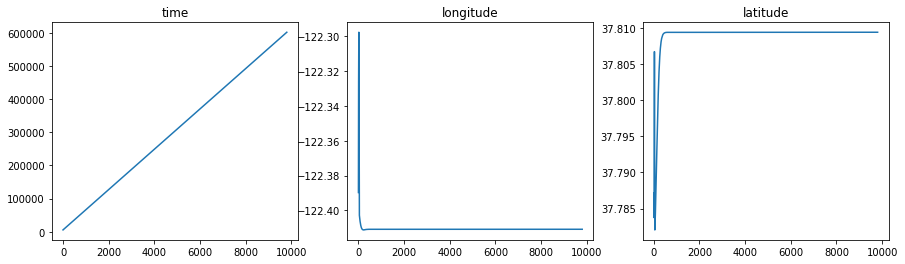

In [36]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.plot(data[i][:, 0])
plt.title('time')
plt.subplot(132)
plt.plot(data[i][:, 1])
plt.title('longitude')
plt.subplot(133)
plt.plot(data[i][:, 2])
plt.title('latitude')
plt.show()

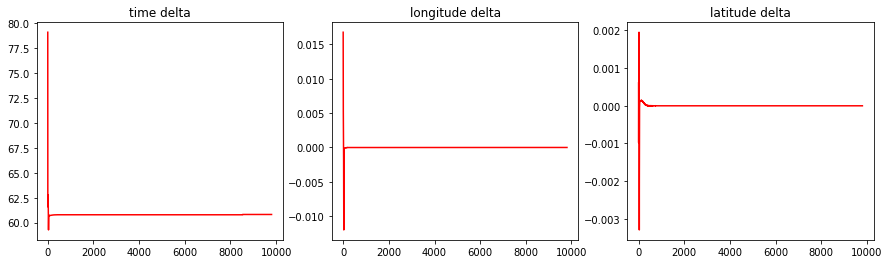

In [37]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.plot(np.diff(data[i][:, 0]), c='red')
plt.title('time delta')
plt.subplot(132)
plt.plot(np.diff(data[i][:, 1]), c='red')
plt.title('longitude delta')
plt.subplot(133)
plt.plot(np.diff(data[i][:, 2]), c='red')
plt.title('latitude delta')
plt.show()

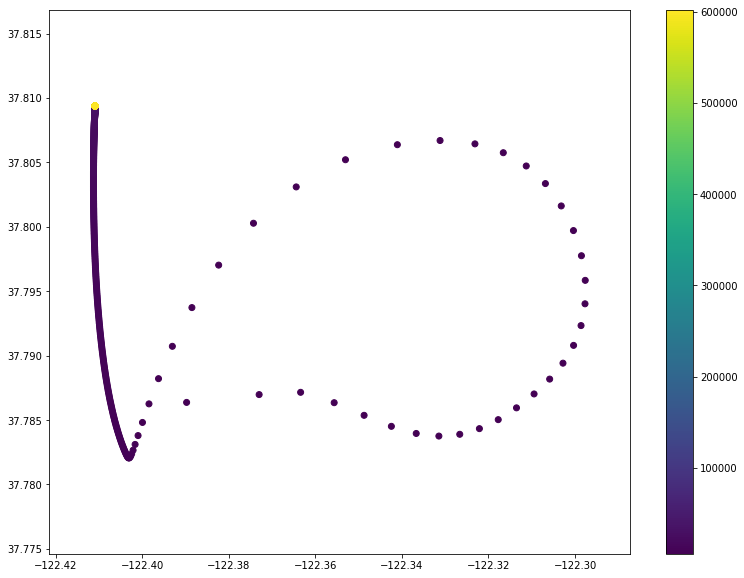

In [41]:
plt.figure(figsize=(13, 10))
plt.scatter(data[i][:, 1], data[i][:, 2], c=data[i][:, 0])
plt.colorbar()
plt.show()

## Convert data to standard format

In [73]:
dfs = []
for u in range(len(data)):
    userdf = pd.DataFrame(data[u], columns=['time', 'longitude', 'latitude'])
    userdf['user'] = u
    userdf['time'] = BEGIN + pd.to_timedelta(userdf['time'], unit='s')
    dfs.append(userdf)

df = pd.concat(dfs, ignore_index=True)
df = df.set_index(['user', 'time'])

df.head()

longitude   latitude
user time                                                
0    2008-06-02 02:13:06.172680544 -122.440272  37.795533
     2008-06-02 02:14:29.331054688 -122.450600  37.805393
     2008-06-02 02:15:39.968750000 -122.458244  37.807407
     2008-06-02 02:16:46.057617188 -122.463585  37.809772
     2008-06-02 02:17:48.258789062 -122.467300  37.811417

In [78]:
df.to_pickle('generated/citybased_rnn_2/' + setup_string + '_cut.pkl')